# AIML CA1

## Import General Dependencies

In [1]:
# Mathematical Dependencies
import numpy as np

# Data Manipulation Dependencies
import pandas as pd

# Graphing Dependencies
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Dependencies
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale, StandardScaler
from sklearn.pipeline import Pipeline

# Miscellaneous Dependencies
from typing import Callable, Dict # static typing

# Utility Functions
from utils.extraction import extract_attributes

In [21]:
%matplotlib inline

## Utility Functions

## Part I

### Import Exclusive Dependencies

In [2]:
# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Classification Metrics
from sklearn.metrics import confusion_matrix

### Import Data

In [3]:
# Extract raw content of ./data/agaricus-lepiota.names file
metadata: str
with open('./data/agaricus-lepiota.names') as f:
    metadata = f.read()

# Extract attributes from metadata
attrs = extract_attributes(metadata, r'7\. Attribute Information:.*\n((.|\n)*)8\. Missing')

# Extract column names to be used for dataframe
cols = attrs.keys()

In [4]:
# Create the dataframe from ./data/agaricus-lepiota.data file,
#   using column names derived from ./data/agaricus-lepiota.names file
df = pd.read_csv(
    filepath_or_buffer='./data/agaricus-lepiota.data',
    sep=',',
    header=0,
    names=cols
)

# Expand attribute codes to their full definitions
for col in cols:
    df[col].replace(to_replace=attrs[col] ,inplace=True)

#### Inspect Data

In [5]:
# Inspect top 10 rows of the dataset
df.head(n=10)

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
1,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
2,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
3,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
4,edible,convex,scaly,yellow,bruises,almond,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,black,numerous,grasses
5,edible,bell,smooth,white,bruises,almond,free,close,broad,gray,...,smooth,white,white,partial,white,one,pendant,black,numerous,meadows
6,edible,bell,scaly,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,scattered,meadows
7,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,pink,...,smooth,white,white,partial,white,one,pendant,black,several,grasses
8,edible,bell,smooth,yellow,bruises,almond,free,close,broad,gray,...,smooth,white,white,partial,white,one,pendant,black,scattered,meadows
9,edible,convex,scaly,yellow,bruises,anise,free,close,broad,gray,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses


#### Summarize Data

In [6]:
# Inspect overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8123 non-null   object
 1   cap-shape                 8123 non-null   object
 2   cap-surface               8123 non-null   object
 3   cap-color                 8123 non-null   object
 4   bruises?                  8123 non-null   object
 5   odor                      8123 non-null   object
 6   gill-attachment           8123 non-null   object
 7   gill-spacing              8123 non-null   object
 8   gill-size                 8123 non-null   object
 9   gill-color                8123 non-null   object
 10  stalk-shape               8123 non-null   object
 11  stalk-root                8123 non-null   object
 12  stalk-surface-above-ring  8123 non-null   object
 13  stalk-surface-below-ring  8123 non-null   object
 14  stalk-color-above-ring  

In [7]:
# Inspect statistics of the dataset
df.describe().transpose()

,count,unique,top,freq
class,8123,2,edible,4208
cap-shape,8123,6,convex,3655
cap-surface,8123,4,scaly,3244
cap-color,8123,10,brown,2283
bruises?,8123,2,no,4748
odor,8123,9,none,3528
gill-attachment,8123,2,free,7913
gill-spacing,8123,2,close,6811
gill-size,8123,2,broad,5612
gill-color,8123,12,buff,1728


### Pre-Processing

#### EDA

In [33]:
# Check for missing values
df.isna().sum(axis=0)

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises?                    0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [50]:
df_unique = df.describe().transpose()['unique']
df_unique[df_unique < 2]
pd.unique(df['veil-type'].values)

array(['partial'], dtype=object)

In [52]:
df.drop(labels='veil-type', inplace=True, axis=1)

In [62]:
df_ohe = pd.get_dummies(data=df, drop_first=True)
df_ohe.corr()['class_poisonous'].sort_values(key=lambda x: np.abs(x), ascending=False)

class_poisonous                   1.000000
odor_none                        -0.785534
odor_foul                         0.623974
stalk-surface-above-ring_silky    0.587794
stalk-surface-below-ring_silky    0.573656
                                    ...   
cap-shape_convex                 -0.027031
cap-shape_conical                 0.023012
cap-surface_grooves               0.023012
cap-shape_flat                    0.018629
stalk-surface-above-ring_scaly   -0.016192
Name: class_poisonous, Length: 96, dtype: float64

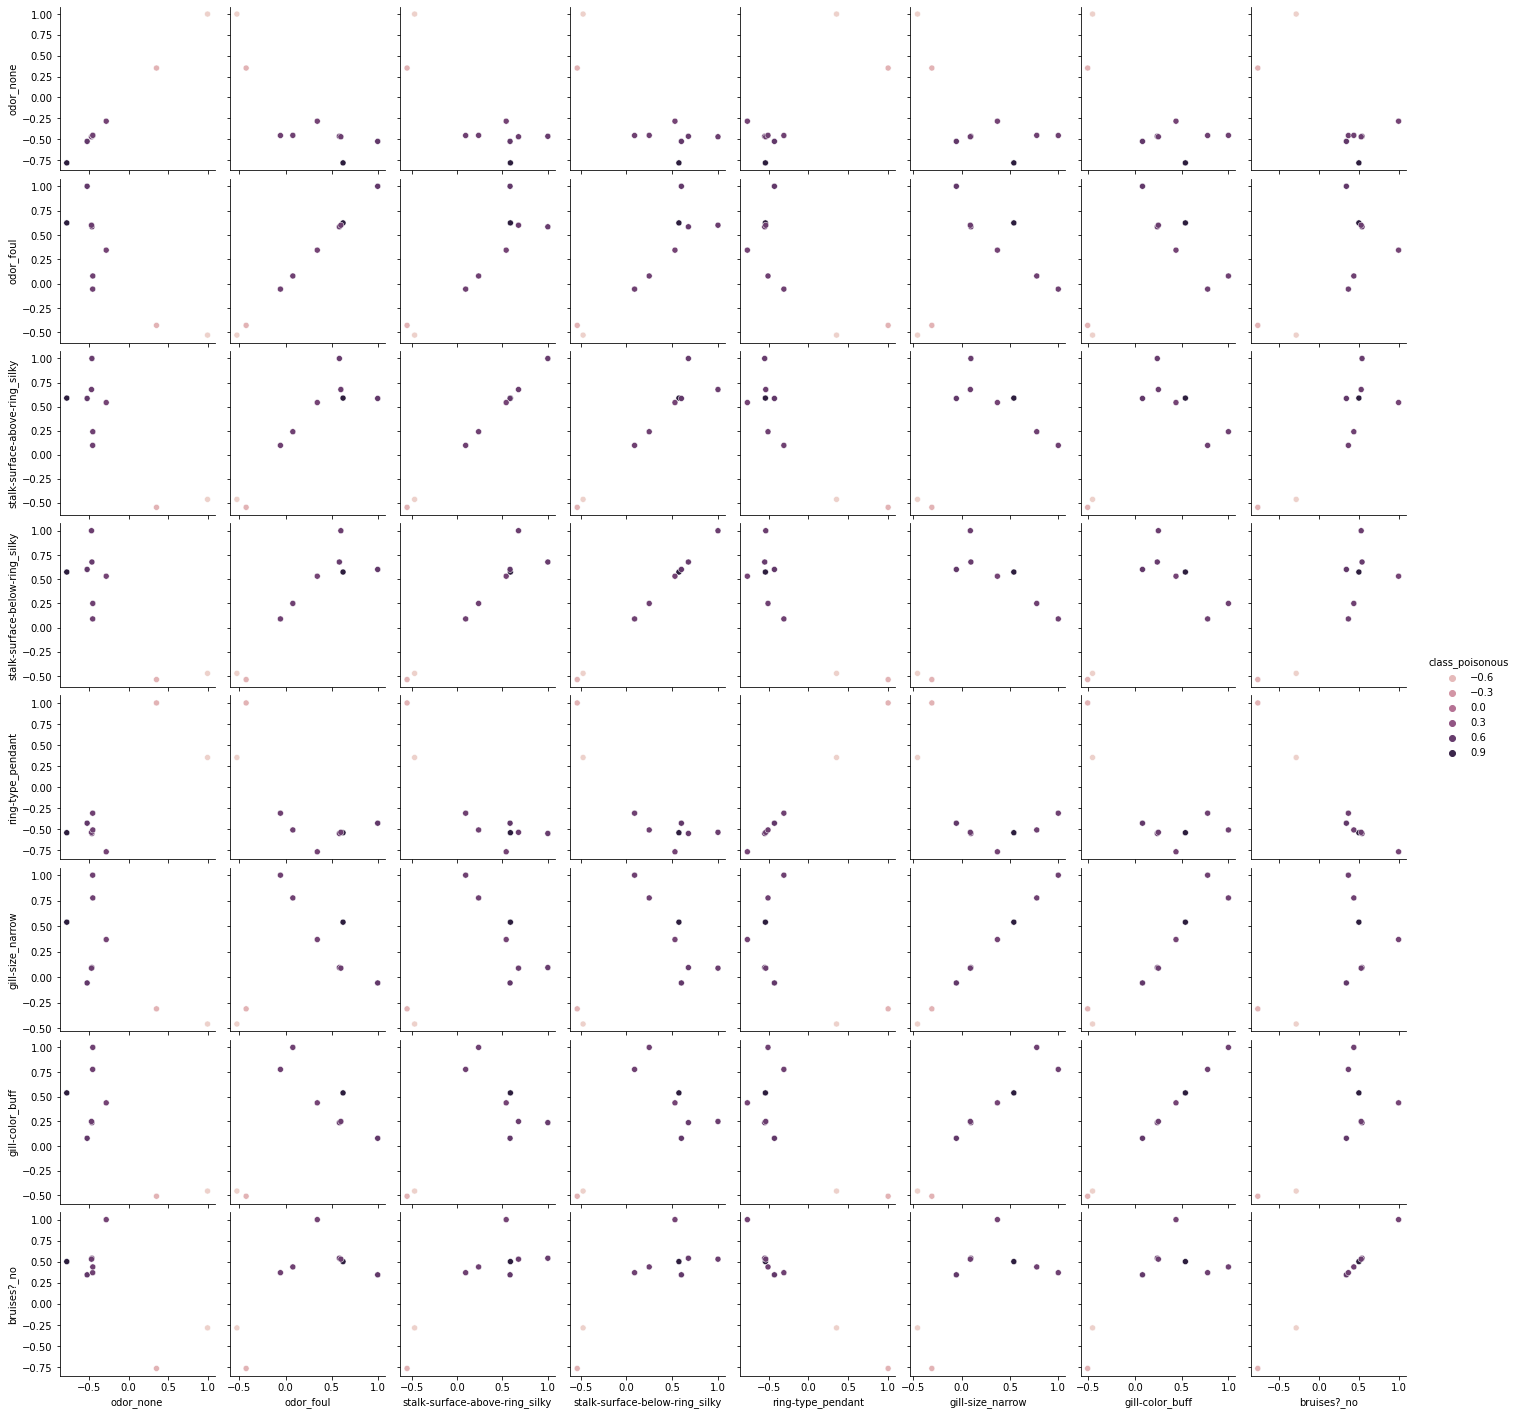

In [9]:
# # Check correlation between attributes
# with pd.option_context('display.max_rows', None):
#     yoyo = pd.get_dummies(df, drop_first=True)
#     df_corr = yoyo.corr()
#     df_corr_targ = df_corr
#     df_minor_mask = df_corr_targ.apply(func=lambda s: np.abs(s['class_poisonous']) > 0.5)
#     df_corr_sort = df_corr_targ[df_minor_mask].sort_values(by='class_poisonous', key=lambda s: -np.abs(s))
#     # df_corr_sort.drop(labels='class_poisonous', inplace=True)
#     targeted_corr = df_corr.loc[df_corr_sort.index.values, df_corr_sort.index.values]
#     sns.pairplot(targeted_corr, hue='class_poisonous', diag_kind=None)

In [10]:
# chi square
from sklearn.feature_selection import chi2, SelectKBest

# t = pd.get_dummies(df, drop_first=True).groupby(by='class_poisonous').sum().astype(int)
t = pd.get_dummies(df).drop(labels='class_edible', axis=1)

s = SelectKBest(score_func=chi2, k=5).fit(t.drop(labels='class_poisonous', axis=1), t[['class_poisonous']])
good_preds = t.drop(labels='class_poisonous', axis=1).columns.values[s.get_support()]
sns.pairplot(data=t.drop(labels=t.columns.values[t.columns.values]))

IndexError: arrays used as indices must be of integer (or boolean) type

In [53]:
dfdf = pd.get_dummies(df, drop_first=True)

<AxesSubplot:title={'center':'General Data Distribution'}, xlabel='Type', ylabel='Number of Records'>

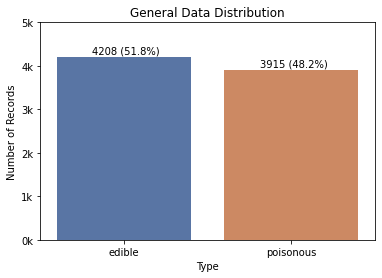

In [22]:
from utils.plotting import format_label
def plot_A(df: pd.DataFrame):
    ax = sns.countplot(data=df, x='class', palette='deep')
    ax.set_ylim(top=5000)
    ax.set_title(label='General Data Distribution')
    ax.set_ylabel(ylabel='Number of Records')
    ax.set_yticklabels(labels=format_label(
        ax.get_yticks() / 1000, lambda s: f'{round(s)}k'))
    ax.set_xlabel(xlabel='Type')
    total_count = df.shape[0]
    for p in ax.patches:
        x = p.get_x()
        y = p.get_height()
        ax.annotate(text=f'{y} ({y/total_count*100:.1f}%)',
                    xy=(x + 0.21, y + 70))  # type: ignore
    return ax
ax_a = plot_A(df=df)
ax_a

### Data Partitioning

In [65]:
X = df_ohe.drop(labels='class_poisonous', axis=1)
y = df_ohe['class_poisonous']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Model Training

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [67]:
knn = KNeighborsClassifier(n_neighbors=4)

knn.fit(X_train, y_train)
knn.score(X_test, y_test)
# confusion_matrix(y_test, knn.predict(X_test))
# knn.predict(X_test.iloc[0:1,:])
# print(X_test.shape)

1.0

[0.9489212  0.95483374 0.95187747 0.95434016 0.95298439 0.95384779
 0.95384658 0.95446344 0.95372355 0.95384755 0.95433907 0.95483277
 0.95446271 0.95532551 0.95470938 0.95544878 0.95520187 0.95631061
 0.95544854]


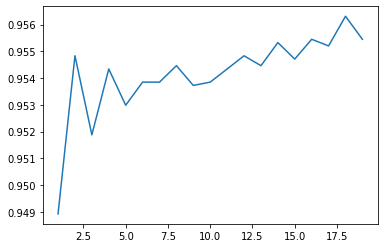

In [94]:
neighbours_range = list(range(1, 20))
# fig, ax = plt.subplots(nrows=1, ncols=len(neighbours_range), sharey=True)
result = np.empty(shape=(0,))
for neighbours in neighbours_range:
    cv = cross_val_score(estimator=KNeighborsClassifier(n_neighbors=neighbours), X=X, y=y, cv=8)
    # print(f"Neighbours: {neighbours}\t| Mean: {cv.mean()}\t| Median: {np.median(cv)}")
    result = np.hstack((result, np.array([cv.mean()])))
    # sns.swarmplot(y=cv, ax=ax[neighbours - 3])

sns.lineplot(x=neighbours_range, y=result)
print(result)
# fig.show()

In [82]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', DummyEstimator())
])

params = [
    {
        'clf': [KNeighborsClassifier()],
        'clf__n_neighbors': np.arange(start=1, stop=10)
    },
    {
        'clf': [LogisticRegression()]
    }
]

cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=5)
cv.fit(X=X, y=y)
print(cv.best_params_)
print(cv.best_score_)
print(cv.best_estimator_)
pd.DataFrame(data=cv.cv_results_)

{'clf': LogisticRegression()}
0.9998768472906404
Pipeline(steps=[('scaler', StandardScaler()), ('clf', LogisticRegression())])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038214,0.005130,0.249093,0.014486,KNeighborsClassifier(),1,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",1.000000,1.0,1.000000,1.000000,0.991379,0.998276,0.003448,2
1,0.035461,0.004518,0.273953,0.048609,KNeighborsClassifier(),2,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",1.000000,1.0,1.000000,0.996921,0.977833,0.994951,0.008642,5
2,0.039673,0.004578,0.296076,0.007430,KNeighborsClassifier(),3,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.998769,1.0,1.000000,0.996921,0.987069,0.996552,0.004874,3
3,0.032610,0.003196,0.354940,0.016316,KNeighborsClassifier(),4,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.998769,1.0,0.999385,0.996921,0.987069,0.996429,0.004792,4
4,0.037249,0.004826,0.354254,0.021836,KNeighborsClassifier(),5,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.982769,1.0,0.999385,0.993227,0.980911,0.991258,0.008068,7
5,0.035779,0.002425,0.336349,0.018447,KNeighborsClassifier(),6,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.985846,1.0,0.999385,0.991379,0.983990,0.992120,0.006646,6
6,0.035190,0.002628,0.320683,0.009479,KNeighborsClassifier(),7,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.977231,1.0,0.999385,0.988916,0.981527,0.989412,0.009191,9
7,0.035692,0.001307,0.338590,0.010173,KNeighborsClassifier(),8,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.982154,1.0,0.999385,0.987069,0.985222,0.990766,0.007458,8
8,0.034520,0.002507,0.342330,0.023315,KNeighborsClassifier(),9,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.976615,1.0,0.999385,0.988916,0.976601,0.988303,0.010330,10
9,0.107747,0.014458,0.005067,0.000776,LogisticRegression(),NaN,{'clf': LogisticRegression()},1.000000,1.0,1.000000,1.000000,0.999384,0.999877,0.000246,1


## Part II

### Import Exclusive Dependencies

In [57]:
# Machine Learning Models (Regression)
from sklearn.linear_model import LinearRegression, BayesianRidge

### Import Data

In [84]:
# 
df2 = pd.read_csv('./data/kc_house_data.csv')

#### Inspect Data

In [59]:
df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


#### Summarize Data

In [60]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [61]:
df2.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
id,21613.0,4.580302e+09,2.876566e+09,1000102.00,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.400881e+05,3.671272e+05,75000.00,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21613.0,3.370000e+00,9.300000e-01,0.00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21613.0,2.110000e+00,7.700000e-01,0.00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21613.0,2.079900e+03,9.184400e+02,290.00,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21613.0,1.510697e+04,4.142051e+04,520.00,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.490000e+00,5.400000e-01,1.00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,1.000000e-02,9.000000e-02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.300000e-01,7.700000e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21613.0,3.410000e+00,6.500000e-01,1.00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


### Pre-Processing

#### EDA

In [62]:
# Check for missing values
df2.isna().any(axis=0)

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [63]:
# df3 = StandardScaler.fit_transform(df2)
# df3.head()

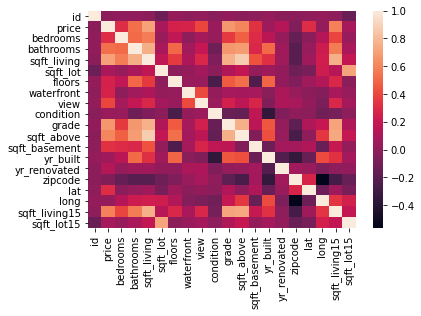

In [89]:
sns.heatmap(df2.corr())

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

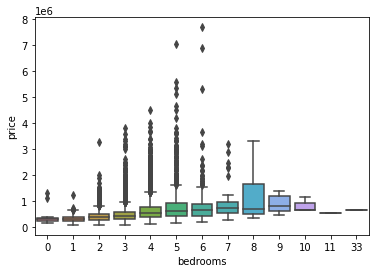

In [64]:
sns.boxplot(data=df2, x='bedrooms', y='price')

In [65]:
sns.boxplot(data=df_tmp, x='bedrooms', y='price')

NameError: name 'df_tmp' is not defined

In [26]:
# Check for outliers
outliers2 = df2[df2['']]

KeyError: ''

#### Feature Engineering

#### Feature Selection

In [59]:
df2['date']

0        20141013T000000
1        20141209T000000
2        20150225T000000
3        20141209T000000
4        20150218T000000
              ...       
21608    20140521T000000
21609    20150223T000000
21610    20140623T000000
21611    20150116T000000
21612    20141015T000000
Name: date, Length: 21613, dtype: object

In [71]:
df2_corr = df2.corr()
df2_corr.drop(labels=df2_corr.columns[df2_corr.columns != 'price'].values, axis=1).drop(labels='price', axis=0)['price'].sort_values(ascending=False)

sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64

### Data Partitioning

In [117]:
X2 = df_tmp[['sqft_living', 'grade']]
y2 = df_tmp['price']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

#! delete !#
model2 = LinearRegression()
model2.fit(X=X2_train, y=y2_train)
print(model2.score(X2_train, y2_train))
print(model2.score(X2_test, y2_test))

0.6144714955890475
0.6120830223958837


### Model Training

In [119]:
model2 = LinearRegression()
model2.fit(X=X2_train, y=y2_train)
print(model2.score(X2_train, y2_train))
print(model2.score(X2_test, y2_test))

0.6144714955890475
0.6120830223958837


In [118]:
model2 = BayesianRidge()
model2.fit(X=X2_train, y=y2_train)
print(model2.score(X2_train, y2_train))
print(model2.score(X2_test, y2_test))

0.6144714650952643
0.6120755718675807


In [121]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, Lars

for m in [Ridge, Lasso, ElasticNet, Lars]:
    p = m()
    try:
        p.fit(X2_train, y2_train)
        print(p.score(X2_test, y2_test))
    except Exception:
        pass

0.6120830223909768
c:\Users\ethanol\Documents\SP\Current\AI and Machine Learning (AIML)\CA1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56037237319947.92, tolerance: 24904296381.3108
  model = cd_fast.enet_coordinate_descent(
0.541520468522968
0.541520468544832
0.6120830223986291
c:\Users\ethanol\Documents\SP\Current\AI and Machine Learning (AIML)\CA1\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56037241180363.42, tolerance: 24904296381.3108
  model = cd_fast.enet_coordinate_descent(


### Model Scoring

### Model Evaluation

## Conclusions